In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Conv3D, ConvLSTM2D, BatchNormalization, Flatten, MaxPooling2D
import pickle
from keras.optimizers import Adam
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import ClusterCentroids

Using TensorFlow backend.


In [2]:
start_time = time.clock()
np.random.seed(7)
random.seed(7)

tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess = print(tf.Session(config=tf.ConfigProto(log_device_placement=True)))

In [3]:
file_path = '../../data/input/integrated_data_dummy.csv'

input_data = pd.read_csv(file_path)

In [4]:
input_data.shape

(1657774, 456)

In [5]:
data = input_data[:50000]
data.shape

(50000, 456)

In [6]:
del input_data

In [7]:
data.isnull().any()

route                                                False
tripNum                                              False
shapeSequence                                        False
shapeLat                                             False
shapeLon                                             False
distanceTraveledShape                                False
busCode                                              False
gpsPointId                                           False
gpsLat                                               False
gpsLon                                               False
distanceToShapePoint                                 False
stopPointId                                          False
precipitation                                        False
alertRoadType                                        False
alertConfidence                                      False
alertNComments                                       False
alertNImages                                         Fal

In [8]:
# Class count
count_class_0, count_class_1 = data.busBunching.value_counts()

# Divide by class
df_class_0 = data[data['busBunching'] == 0]
df_class_1 = data[data['busBunching'] == 1]

In [9]:
df_class_0_under = df_class_0.sample(count_class_1)
df_data_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_data_under.busBunching.value_counts())

Random under-sampling:
1    4097
0    4097
Name: busBunching, dtype: int64


In [ ]:
df_data_under.shape

In [29]:
y

0        299
1        178
2        187
3        204
4        206
5        210
6        210
7        216
8        222
9        234
10       240
11       242
12       269
13       275
14       268
15       239
16       233
17       223
18       169
19       162
20       160
21       158
22       121
23       194
24       209
25       255
26       271
27       250
28       233
29       215
        ... 
49970     28
49971     31
49972     31
49973     59
49974     57
49975     30
49976     30
49977     53
49978     51
49979     32
49980     49
49981     43
49982     31
49983     31
49984     40
49985     38
49986     37
49987     36
49988     35
49989     35
49990     34
49991     34
49992     34
49993     35
49994     40
49995     40
49996     38
49997     42
49998     42
49999     44
Name: headway, Length: 50000, dtype: int64

In [10]:
# get label column and remove it from data
y = data['headway']
df_data_under.drop('headway', axis=1, inplace=True)
df_data_under.drop('busBunching', axis=1, inplace=True)

In [11]:
rows = 5 # TODO min quantity of gps points per route (should be the same) 
cols = df_data_under.shape[1] # quantity of attributes
n_samples = df_data_under.shape[0] # all examples
n_frames = 3 # TODO total of routes
n_channels = 1

In [12]:
# convert input data format to multidimensional matrices

total_input = np.zeros((n_samples, n_frames, rows, cols, n_channels), dtype=np.float)
label = np.zeros((n_samples, 1), dtype=int)

for line in range(n_samples):
    for col in range(cols):
#         total_input[line, 0, 0:line, col, 0] = X_resampled.iloc[:,col][line]
        total_input[line, 0, 0:line, col, 0] = df_data_under.iloc[line,col]#X_resampled[line][col]
        
#     label[line, 0] = y_resampled.iloc[line]
    label[line, 0] = y.iloc[line] #y_resampled[line]

# total_input = total_input[:n_samples, :, :, :]
# label = label[:n_samples, 0]

In [14]:
total_input.shape

(8194, 3, 5, 454, 1)

In [15]:
label.shape

(8194, 1)

In [33]:
label

array([[299],
       [178],
       [187],
       ...,
       [ 15],
       [ 15],
       [ 16]])

In [40]:
test_Y

array([[ 30],
       [234],
       [ 18],
       ...,
       [ 63],
       [ 13],
       [ 16]])

In [13]:
# no_class = len(list(set(np.ndarray.flatten(label))))
no_class = 793
threshold = len(total_input[0, 0, :, 0, 0])

# Making training and test data: 80% Training, 20% Test
train_X, test_X, train_Y, test_Y = train_test_split(total_input, label, test_size=0.20, random_state=7)

# Converts a class vector (integers) to binary class matrix
# train_Y = keras.utils.to_categorical(train_Y, num_classes=no_class)
# test_Y = keras.utils.to_categorical(test_Y, num_classes=no_class)

In [14]:
model = Sequential()
# if data_format='channels_last' 4D tensor with shape: (samples, rows, cols, channels)
model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   input_shape=(n_frames, rows, cols, n_channels),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())

# model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())


model.add(Conv3D(filters=16, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))

model.add(Flatten())
# model.add(Dense(model.output_shape[1], activation='relu'))
# model.add(Dropout(.5))

model.add(Dense(no_class, activation='relu'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['mse'])

W0806 13:32:20.184653 140465212090176 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 13:32:20.706665 140465212090176 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 13:32:21.990727 140465212090176 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 13:32:32.765061 140465212090176 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

In [ ]:
# train the network
offline_history = model.fit(train_X, train_Y, batch_size=16, epochs=50, validation_data=(test_X, test_Y))

Train on 6555 samples, validate on 1639 samples
Epoch 1/50
  16/6555 [..............................] - ETA: 40:13 - loss: 17.1902 - mean_squared_error: 2507.4473

In [18]:
offline_history.history

{'val_loss': [16.987955480904898,
  16.987952110751362,
  16.987952110751362,
  16.987952110751362],
 'val_mean_squared_error': [6951.803810142904,
  6960.543739006969,
  6954.860954242774,
  6954.817137331262],
 'loss': [16.97911884910182,
  16.965639692403997,
  16.96563744039412,
  16.96563745174219],
 'mean_squared_error': [6858.945916166094,
  6858.372479410994,
  6859.725192481884,
  6859.728496369363]}

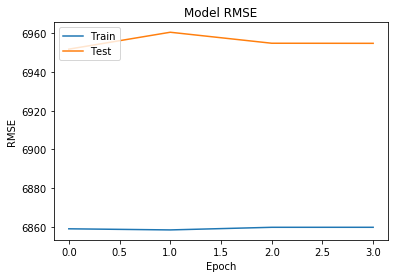

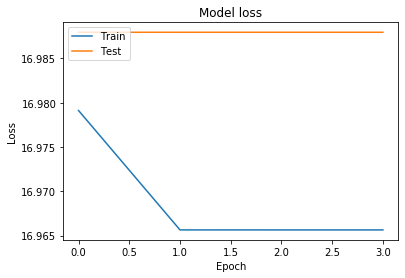

In [19]:
# Plot training & validation accuracy values
plt.plot(offline_history.history['mean_squared_error'])
plt.plot(offline_history.history['val_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(offline_history.history['loss'])
plt.plot(offline_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
A = np.argmax(offline_history.history['val_loss'])
print('the optimal epoch size: {}, the value of less loss {}'.format(offline_history.epoch[A], 
                                                                     np.min(offline_history.history['val_loss'])))

# Calculating the test accuracy, precision, recall
pred = model.predict(test_X, batch_size=16)
pred_label = np.argmax(pred, axis=1)

the optimal epoch size: 0, the value of less loss 16.987952110751362


MSE (Mean Squared Error): Média dos erros quadráticos 

In [24]:
model.metrics_names

['loss', 'mean_squared_error']

In [21]:
model.evaluate(test_X, test_Y)

1639/1639 [==============================] - 104s 63ms/step


[16.987952110751362, 6954.817169505987]

In [23]:
train_Y

array([[86],
       [43],
       [92],
       ...,
       [18],
       [77],
       [60]])

In [24]:
test_Y

array([[ 30],
       [234],
       [ 18],
       ...,
       [ 63],
       [ 13],
       [ 16]])

In [64]:
ActualPositive = []
for i in range(no_class):
    AA = np.where(test_Y == i)[0]
    ActualPositive.append(AA)

PredictedPositive = []
for i in range(no_class):
    AA = np.where(pred_label == i)[0]
    PredictedPositive.append(AA)

TruePositive = []
FalsePositive = []
for i in range(no_class):
    AA = []
    BB = []
    for j in PredictedPositive[i]:
        if pred_label[j] == test_Y[j,1]:
            AA.append(j)
        else:
            BB.append(j)
    TruePositive.append(AA)
    FalsePositive.append(BB)
Precision = []
Recall = []


precision = ( len(TruePositive[0]) + len(TruePositive[1]) ) / ( len(PredictedPositive[0]) + len(PredictedPositive[1]) )
recall = ( len(TruePositive[0]) + len(TruePositive[1]) ) / ( len(ActualPositive[0]) + len(ActualPositive[1]) )

ConfusionM = confusion_matrix(list(test_Y[:,1]), pred_label, labels=[0, 1, 2, 3, 4])

In [65]:
print('Confusion Matrix: ', ConfusionM)
print('Recall', recall)
print('Precision', precision)
print(time.clock() - start_time, "seconds")

Confusion Matrix:  [[753   0   0   0   0]
 [  2   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]
Recall 0.0016968172845515264
Precision 0.9973509933774835
6801.5019090000005 seconds
